# Vehicle Detection & Tracking Using Computer Vision And Machine Learning

When we drive, we constantly pay attention to our environment, as our safety and that of many other people are at stake. We particularly look out for position of potential _obstacles_, whether they be other cars, pedestrians, or object on the road. Similarly, as we develop the intelligence and sensors necessary to power an autonomous vehicle, it is of the utmost importance that such a vehicle can detect obstacles as well, as it reinforces the car's understanding of its environment. One of the most important types of ostacles to detect is other vehicles on the road, as they would most likely be the in our lane or neighbouring ones and therefore constitute a potential hazard.

A number of techniques for obstacle detection have been developed throughout the literature, from traditional computer vision techniques to deep learning ones, and more. In this exercise, we build a vehicle detector by employing a conventional computer vision technique called _Histogram of Oriented Gradients (HOG)_, combined with a machine learning algorithm called _Support Vector Machines (SVM)_.

In [1]:
# Main imports
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [87]:
from importlib import reload
import utils; reload(utils)
from utils import *

In [88]:
test_imgs_dir = "test_images"
output_imgs_dir = "output_images"
output_videos_dir = "output_videos"

project_dataset_dir = "project_dataset"
project_dataset_vehicles_dir = "project_dataset/vehicles"
project_dataset_non_vehicles_dir = "project_dataset/non-vehicles"

# Dataset exploration

Udacity generously provided a _balanced_ dataset with the following characteristics:
* ~ 9K images of vehicles
* ~ 9K images of non-vehicles
* all images are 64x64
The dataset comes from the [GTI Vehicle Image Database](http://www.gti.ssr.upm.es/data/Vehicle_database.html), [KITTI Vision Benchmark Suite](http://www.cvlibs.net/datasets/kitti/), and examples extracted from the project video itself. The latter is much larger and was not used for this project. However, it would be a great addition in the future, especially as we plan to build a classifier using deep learning.

In [89]:
# Let's fetch the paths of training images
project_vehicle_img_paths = glob.glob(project_dataset_vehicles_dir + "/**/*.png", recursive=True)
len(project_vehicle_img_paths)

8792

In [90]:
project_non_vehicle_img_paths = glob.glob(project_dataset_non_vehicles_dir + "/**/*.png", recursive=True)
len(project_non_vehicle_img_paths)

8968

In [91]:
example_vehicle_imgs= np.asarray(list(map(lambda path: load_image(path),  np.asarray(project_vehicle_img_paths)[np.random.randint(0, high=len(project_vehicle_img_paths), size=5)]))) 
example_non_vehicle_imgs= np.asarray(list(map(lambda path: load_image(path),  np.asarray(project_non_vehicle_img_paths)[np.random.randint(0, high=len(project_non_vehicle_img_paths), size=5)]))) 


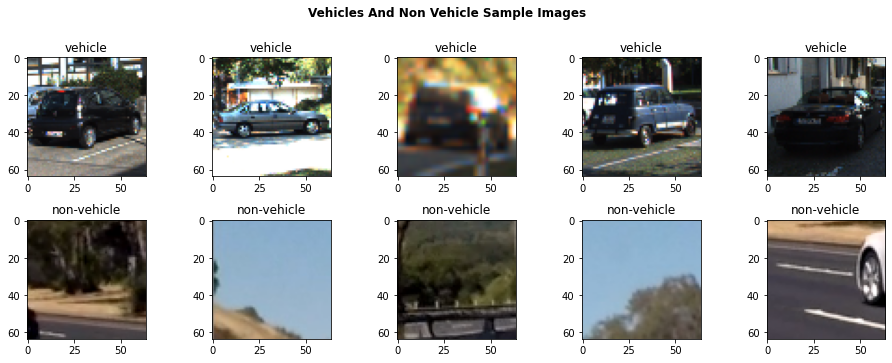

In [92]:
show_image_list([example_vehicle_imgs, example_non_vehicle_imgs], [np.repeat("vehicle", 5), np.repeat("non-vehicle", 5)], 
                "Vehicles And Non Vehicle Sample Images", cols=5, fig_size=(13, 5))


We can clearly see both vehicle and non-vehicle images. Non-vehicle images tend to be other elements of the road such as the asphalt, road signs or pavement. The distinction is very clear. Most images also display the vehicle in the center, but in different orientations, which is good. 

The concern however would be that because the vehicle is the central object of these images, we may be suffering from _translation_ invariance in the dataset (e.g. non image where we see half or less of the vehicle on the side, etc.).

It seems we will have to make sure to feed to our classifier an image where the vehicle is at the center.

# Feature Extraction

In this section, we apply Histogram of Oriented Gradients and Color bins to our input image to create our features, which will then be fed to a classifier. But before we employ these techniques, we must first define a function to subsample our input.

In [93]:
def subsample_image(img, new_size=(32,32), single_vector=True):
    """
    Resizes the image to the new size and returns either a 1-D vector or multi-dimensional matrix depending
    on the value of single_vector
    """
    features = cv2.resize(img, new_size)
    return features.ravel() if single_vector else features

In [94]:
def color_histogram(img, nbins=32, bins_range=(0, 256)):
    """
    Returns the histograms of the color image across all channels, as a concatenanted feature vector
    """
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [95]:
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler

In [96]:
def pick_features(feat_sub_sample, feat_color_hist, feat_hog, 
                  use_sub_sample=False, use_color_hist=True, use_hog=True):
    """
    Returns a feature vector where the different individual features were retained (or not)
    """
    feature_vec = []
    if use_sub_sample:
        feature_vec = feat_sub_sample
    if use_color_hist:
        feature_vec = feat_color_hist if len(feature_vec) == 0 else np.hstack((feature_vec, feat_color_hist))
    if use_hog:
        feature_vec = feat_hog if len(feature_vec) == 0 else np.hstack((feature_vec, feat_hog))
    
    return feature_vec

In [97]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True, b_norm="L2-Hys"):
    """
    Returns a feature matrix (or vector) that contains the result of the Histogram of Oriented gradients computation.
    If feature_vec is set to True, the resulting image is also returned.
    """
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualize=vis, feature_vector=feature_vec, block_norm="L2-Hys")
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualize=vis, feature_vector=feature_vec, block_norm="L2-Hys")
        return features

In [98]:
def compute_features(img, color_space="YCrCb", subsample_size=(32, 32), hist_bins=32, hist_range=(0, 256), 
                    hog_orient=9, hog_pix_per_cell=8, hog_cells_per_block=2, hog_block_norm="L2-Hys",
                    hog_color_channels=[0, 1, 2], hog_grayscale=False):
    """
    Computes the features of the given image, by using a combination of:
    - image subsampling
    - color histogram
    - histogram of gradients
    The vector contains all concatenated (and unscaled) features computed
    """
    img_cspace = change_color_space(img, cspace=color_space)
    img_sub_sample = subsample_image(img_cspace, new_size=subsample_size)
    img_color_hist = color_histogram(img_cspace, nbins=hist_bins, bins_range=hist_range)

    hog_features = []
    if hog_color_channels == None:            
        hog_features, img_hog = hog(to_grayscale(img),  orientations=hog_orient,
                      pixels_per_cell=(hog_pix_per_cell, hog_pix_per_cell), 
                     cells_per_block=(hog_cells_per_block, hog_cells_per_block),
                     block_norm=hog_block_norm, visualize=True, feature_vector=True)
    else:
        for ch in hog_color_channels:
            hf, img_hog = hog(img_cspace[:,:,ch], orientations=hog_orient,
                      pixels_per_cell=(hog_pix_per_cell, hog_pix_per_cell), 
                     cells_per_block=(hog_cells_per_block, hog_cells_per_block),
                     block_norm=hog_block_norm, visualize=True, feature_vector=True)
            hog_features = hf if len(hog_features) == 0 else np.concatenate((hog_features, hf))
        
    return pick_features(img_sub_sample, img_color_hist, hog_features)

In [99]:
def normalise_features(features, normaliser=None):
    """
    Returns the tuple (normalised_features, normaliser), 
    where normaliser can normalise feature data by applying the function normaliser.transform(data).
    The function can accept a default normaliser. If None is provided, one will be created and returned
    """
    stacked_features = np.vstack(features).astype(np.float64)
    if normaliser == None:        
        normaliser = StandardScaler().fit(stacked_features)
    normed_features = normaliser.transform(stacked_features)
    
    return normed_features, normaliser

# Exploration Of Features

Let's explore the result of our HOG operations. The algorithm is well explained by Satya Mallick on this [post](https://www.learnopencv.com/histogram-of-oriented-gradients/). 

In [100]:
class FeatureConfig:
    """
    Stores feature configuration
    """
    def __init__(self, color_space, hog_orientations, hog_pixels_per_cell, hog_cells_per_block, hog_block_norm, hog_color_channels=[0,1,2]):
        self.color_space = color_space
        self.hog_orientations = hog_orientations
        self.hog_pixels_per_cell = hog_pixels_per_cell
        self.hog_cells_per_block = hog_cells_per_block
        self.hog_block_norm = hog_block_norm
        self.hog_color_channels = hog_color_channels

In [101]:
test_configs = [
    FeatureConfig("RGB", 9, 8, 2, "L2-Hys"),
    FeatureConfig("RGB", 9, 10, 2, "L2-Hys"),
    FeatureConfig("RGB", 9, 12, 2, "L2-Hys"),
    FeatureConfig("RGB", 9, 14, 2, "L2-Hys"),
    FeatureConfig("RGB", 9, 16, 2, "L2-Hys"),
    FeatureConfig("RGB", 11, 8, 2, "L2-Hys"),    
    FeatureConfig("RGB", 11, 10, 2, "L2-Hys"),
    FeatureConfig("RGB", 11, 12, 2, "L2-Hys"),
    FeatureConfig("RGB", 11, 14, 2, "L2-Hys"),
    FeatureConfig("RGB", 11, 16, 2, "L2-Hys")
]

In [102]:
def get_features_from_config(img, config):
    """
    Returns the tuple of the image in the configured color space, and a list of hog visualisations for each color channel
    """
    hog_visualisations = []
    cspace_img = change_color_space(img, config.color_space)
    for ch in [0, 1, 2]:
        _, hog_vis = get_hog_features(cspace_img[:,:,ch], config.hog_orientations, config.hog_pixels_per_cell, 
                         config.hog_cells_per_block, b_norm=config.hog_block_norm, vis=True)
        hog_visualisations.append(hog_vis)
    
    return (cspace_img, hog_visualisations)

In [103]:
def get_hog_features_from_multiple_configs(img, configs):
    """
    Returns the tuple (features, labels) resulting from the extraction of hog features for the passed configs
    """
    features = []
    labels = []
    for config in configs:
        cspace_img, hog_imgs = get_features_from_config(img, config)    
        features.append([cspace_img, hog_imgs[0], hog_imgs[1], hog_imgs[2]])
        hog_config_str = "o={0}, px/c={1}, c/bk={2}".format(config.hog_orientations, 
                                                          config.hog_pixels_per_cell, 
                                                          config.hog_cells_per_block)
        labels.append([config.color_space, 
                        "[1]: {0}".format(hog_config_str),
                        "[2]: {0}".format(hog_config_str),
                        "[3]: {0}".format(hog_config_str)])
    
    return (features, labels)

In [104]:
sample_vehicle_img = example_vehicle_imgs[np.random.randint(0, len(example_vehicle_imgs))]
sample_non_vehicle_img = example_non_vehicle_imgs[np.random.randint(0, len(example_non_vehicle_imgs))]

In [105]:
vehicle_imgs_hog, vehicle_imgs_hog_labels = get_hog_features_from_multiple_configs(sample_vehicle_img, test_configs)

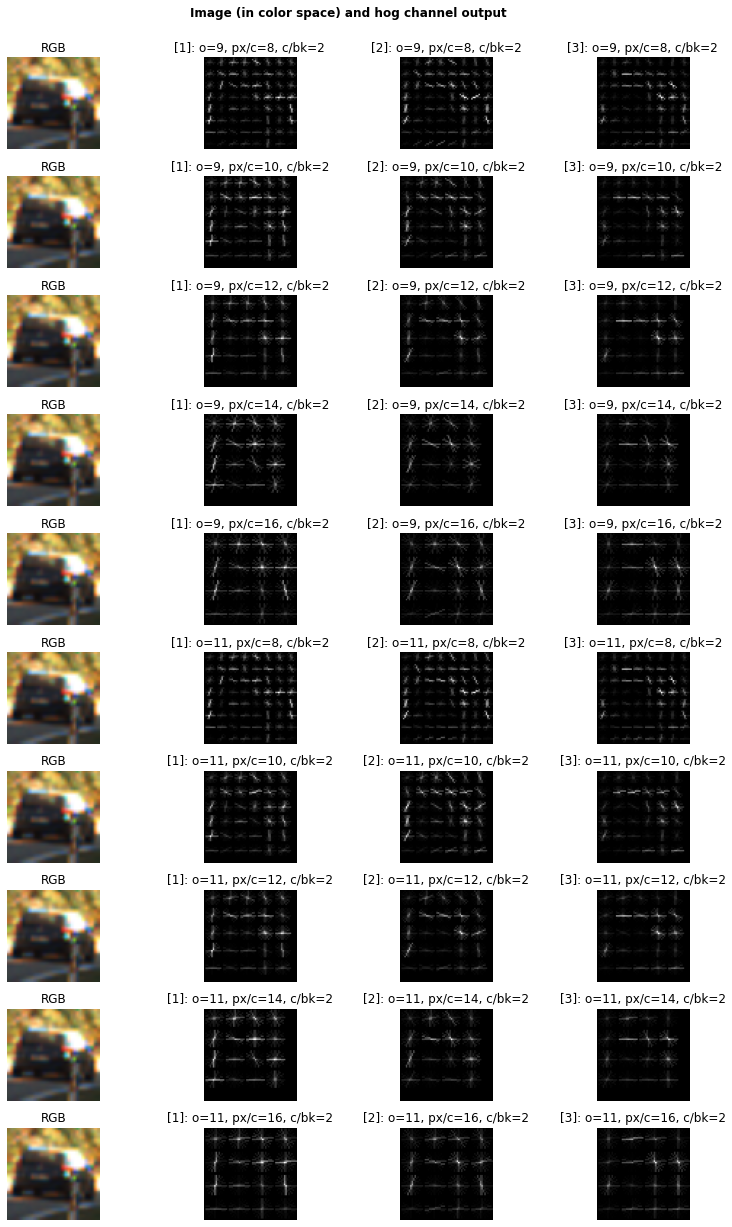

In [106]:
show_image_list(vehicle_imgs_hog, vehicle_imgs_hog_labels, 
                "Image (in color space) and hog channel output", cols=4, fig_size=(12, 17), show_ticks=False)

From pure observation, it looks like a HOG configuration with:
* 11 orientations
* 14 pixels per cell
* 2 cells per blocks 
produce the most distinctive gradients of a vehicle. We have not experimented with different blocks per cells so let us try now.

In [107]:
test_configs = [
    FeatureConfig("RGB", 11, 14, 2, "L2-Hys"),
    FeatureConfig("RGB", 11, 14, 3, "L2-Hys"),
    FeatureConfig("RGB", 11, 14, 4, "L2-Hys")
]

In [108]:
vehicle_imgs_hog, vehicle_imgs_hog_labels = get_hog_features_from_multiple_configs(sample_vehicle_img, test_configs)

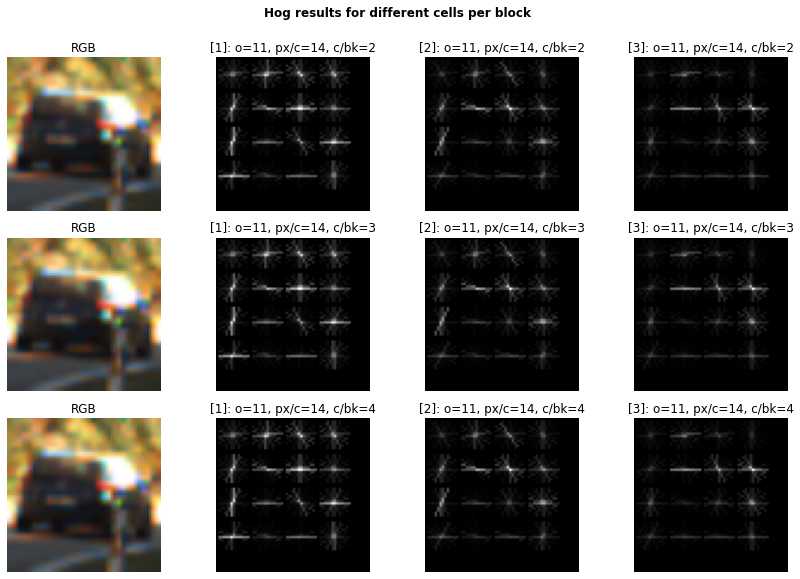

In [109]:
show_image_list(vehicle_imgs_hog, vehicle_imgs_hog_labels, 
                "Hog results for different cells per block", cols=4, fig_size=(12, 8), show_ticks=False)

To the human eye, there is no significant difference that we notice visually. We would ideally like to reduce the feature space for faster computation. But for now, we will settle for now on 2 cells per block as it is commonly used in the literature.

We must now explore the most suitable color space for our configuration, as it seems our hog features across the 3 RGB channels are too similar, therefore it feels we are not generating features with enough variations.

## Finding Suitable Color Space

In [110]:
test_configs = [
    FeatureConfig("RGB", 11, 14, 2, "L2-Hys"),
    FeatureConfig("HSV", 11, 14, 2, "L2-Hys"),
    FeatureConfig("HLS", 11, 14, 2, "L2-Hys"),
    FeatureConfig("YUV", 11, 14, 2, "L2-Hys"),
    FeatureConfig("YCrCb", 11, 14, 2, "L2-Hys"),
    FeatureConfig("LAB", 11, 14, 2, "L2-Hys")
]

In [111]:
vehicle_imgs_hog, vehicle_imgs_hog_labels = get_hog_features_from_multiple_configs(sample_vehicle_img, test_configs)

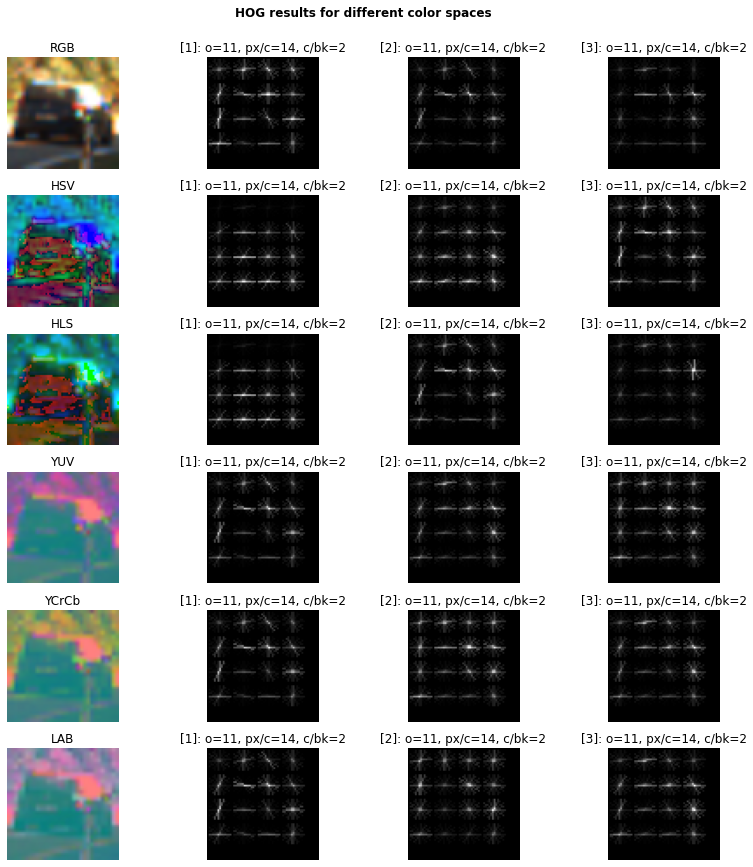

In [112]:
show_image_list(vehicle_imgs_hog, vehicle_imgs_hog_labels, 
                "HOG results for different color spaces", cols=4, fig_size=(12, 12), show_ticks=False)

For some color channels, it is difficult to interpret the result of HOG. Interestingly, it seems the first color channel in YUV, YCrCb, and LAB could be enough to capture the gradients we are looking for. In HSV and HLS it is respectively on the _Value_ and _Lightness_ that HOG captures the most significant features for the vehicle.

To confirm our hypothesis, let us try with a different image of vehicle.

In [113]:
sample_vehicle_img = example_vehicle_imgs[np.random.randint(0, len(example_vehicle_imgs))]

In [114]:
hog_features, hog_labels = get_hog_features_from_multiple_configs(sample_vehicle_img, test_configs)

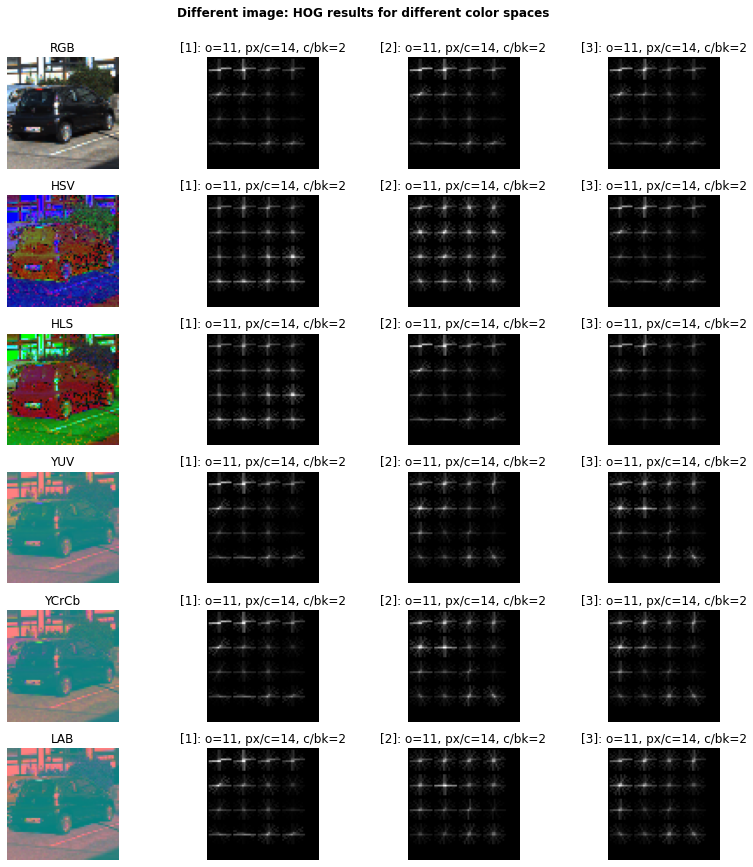

In [115]:
show_image_list(hog_features, hog_labels, 
                "Different image: HOG results for different color spaces", cols=4, fig_size=(12, 12), show_ticks=False)

On a dark image such as the one above, we can observe that HOG on the channel that carries the most light information produces bad results. **We must therefore take into account all color channel to capture the most features.**
In the end, our configuration looks as follows:
* **ALL channels of YCrCb color space**
* **HOG orientations of 11**
* **HOG pixels per cell of 14**
* **HOG cells per cell of 2**

We will also be adding color information to strengthen our feature set.

# Classification

In [116]:
def extract_dataset_features(classes_imgs, labels, config):
    """
    Extract features from labeled dataset
    The list (normalised_features, labels, normaliser) is returned
    """
    all_features = []
    all_labels = []
    for i, class_imgs in enumerate(classes_imgs):
        class_features = []
        class_labels = np.repeat(labels[i], len(class_imgs))
        all_labels = class_labels if len(all_labels) == 0 else np.concatenate((all_labels, class_labels))
        for class_img_path in class_imgs:
            img = load_image(class_img_path)
            img_features = compute_features(img, color_space=config.color_space, 
                                            hog_orient=config.hog_orientations, 
                                            hog_pix_per_cell=config.hog_pixels_per_cell,
                                            hog_cells_per_block=config.hog_cells_per_block,
                                            hog_color_channels=config.hog_color_channels)
            class_features.append(img_features)

        all_features.append(class_features)
    
    normed_features, normaliser = normalise_features(all_features)    
    return normed_features, all_labels, normaliser    

In [117]:
feature_config = FeatureConfig("YCrCb", 11, 14, 2, "L2-Hys", hog_color_channels=[0,1,2])

In [118]:
data_features, data_labels, normaliser = extract_dataset_features([project_vehicle_img_paths, project_non_vehicle_img_paths], ["vehicle", "non_vehicle"], feature_config)

In [119]:
save_as_pickle(data_features, "features_Hist_ALL_HOG-11-14-2_YCrCb.p")

In [120]:
save_as_pickle(data_labels, "data_labels_Hist_ALL_HOG-11-14-2_YCrCb.p")
save_as_pickle(normaliser, "normaliser_Hist_ALL_HOG-11-14-2_YCrCb.p")

In [121]:
normaliser = load_as_pickle("normaliser_Hist_ALL_HOG-11-14-2_YCrCb.p")
data_features = load_as_pickle("features_Hist_ALL_HOG-11-14-2_YCrCb.p")
data_labels = load_as_pickle("data_labels_Hist_ALL_HOG-11-14-2_YCrCb.p")

In [122]:
len(data_labels)

17760

In [123]:
data_features.shape

(17760, 1284)

In [124]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [125]:
def split_dataset(data, labels, test_pct=0.2):
    """
    Splits the dataset into with training having a proportion of 1 - test_pct, and the test set with propotion test_pct 
    Returns the tuple (X_train, y_train), (X_test, y_test)
    """
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_pct)
    return (X_train, y_train), (X_test, y_test)

In [126]:
def train_classifier(data, labels, method="LinearSVC"):
    """
    Train a classifier on the data and labels and returns the trained classifier
    The classifier itself can be chosen from a variety of options. The default is SVM    
    """
    cfier = None
    if method == "LinearSVC":
        cfier = LinearSVC(C=100)
    elif method == "RBFSVC":
        cfier = SVC(C=100)
    elif method == "DecisionTree":
        cfier = DecisionTreeClassifier()        
    
    cfier.fit(data, labels)

    return cfier

In [127]:
def train_classifier_grid_search(data, labels, method="SVM"):
    parameters = {}
    cfier = None
    if method == "SVM":    
        parameters = {'kernel':('linear', 'rbf'), 'C':[1, 100, 1000, 10000], "gamma":["auto", 0.01, 0.1, 1]}
        cfier = SVC()
    
    cfier_gs = GridSearchCV(cfier, parameters, n_jobs=2, verbose=5)
    cfier_gs.fit(data, labels)
    
    return cfier_gs

In [128]:
training_dataset, test_dataset = split_dataset(data_features, data_labels)

In [129]:
print(training_dataset[0].shape, training_dataset[1].shape)

(14208, 1284) (14208,)


In [130]:
print(test_dataset[0].shape, test_dataset[1].shape)

(3552, 1284) (3552,)


In [131]:
classifier_grid_search = train_classifier_grid_search(training_dataset[0], training_dataset[1])

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  4.2min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed: 154.0min
[Parallel(n_jobs=2)]: Done 160 out of 160 | elapsed: 480.2min finished


In [132]:
classifier_grid_search.best_params_

{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}

In [133]:
save_as_pickle(classifier_grid_search, "classifier_Grid_Search_SVC_Hist_ch0_HOG-11-14-2_YCrCb.p")

In [134]:
classifier = classifier_grid_search

In [135]:
simple_classifier = train_classifier(training_dataset[0], training_dataset[1], method="LinearSVC")
better_classifier = train_classifier(training_dataset[0], training_dataset[1], method="RBFSVC")

In [136]:
save_as_pickle(classifier, "classifier_SVC-RBF_Hist_ALL_HOG-11-14-2_YCrCb.p")

In [137]:
classifier = load_as_pickle("classifier_SVC-RBF_Hist_ALL_HOG-11-14-2_YCrCb.p")

In [138]:
simple_preds = simple_classifier.predict(test_dataset[0])
better_preds = better_classifier.predict(test_dataset[0])

In [139]:
print("Simple classifier accuracy={0} - Better classifier accuracy={1}".format(
    accuracy_score(test_dataset[1], simple_preds),
    accuracy_score(test_dataset[1], better_preds)))

Simple classifier accuracy=0.9904279279279279 - Better classifier accuracy=0.995213963963964


# Pipeline

In [140]:
test_imgs_paths = glob.glob(test_imgs_dir + "/*.jpg", recursive=True)

In [141]:
test_imgs = np.asarray(list(map(lambda img_path: load_image(img_path), test_imgs_paths)))

## Multi Scale Sliding Windows

In [142]:
import math
def multi_scale_pipeline(img, x_start, x_stop, y_start, y_stop, scale, cfier, normaliser, 
                         orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                         window=64, color_space="YCrCb", correct_label="vehicle", overlap_cells=4):
    draw_img = np.copy(img)
    # Normalise our input image
    img = change_color_space(img, cspace=color_space).astype(np.float32)
        
    # Define the image portion we are interested in
    img_tosearch = img[y_start:y_stop, x_start:x_stop, :]
    ctrans_tosearch = img_tosearch
    
    # Subsample this search section if needed
    if scale != 1:
        imshape = ctrans_tosearch.shape 
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define the total number of cells in a given direction (x, y) 
    # This is equivalent to the number of convolutions per axis in deep learning (c.f. cs231n)
    # nxblock = [(axis_size - block_size) / stride] + 1 
    #  -> [(axis_size - pix_per_cell * cells_per_block) / pix_per_cell] + 1
    #  -> [(axis_size / pix_per_cell) - cells_per_block] + 1
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    # Each cell within a block is normalised and produces a histogram of oriented features
    nfeat_per_block = orient*cell_per_block
    
    # 64x64 was the orginal sampling rate
    # Same here - we use the convolution formula to figure out the number of blocks in the window
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    
    # Define how many steos we overlap
    cells_per_step = overlap_cells

    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bounding_boxes = []
    all_windows = []
    for xb in range(nxsteps):
        xpos = xb*cells_per_step
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (window,window))
          
            # Get color features
            spatial_features = subsample_image(subimg, new_size=spatial_size)
            hist_features = color_histogram(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            picked_features = pick_features(spatial_features, hist_features, hog_features)

            if len(picked_features.shape) == 1:
                picked_features = picked_features.reshape(1, -1)

            test_features = normaliser.transform(picked_features)
            test_prediction = cfier.predict(test_features)
            
            # Compute our window's actual size
            xbox_left = np.int(xleft * scale)
            ytop_draw = np.int(ytop * scale)
            win_draw = np.int(window * scale)
            
            top_left = (xbox_left + x_start, ytop_draw+y_start)
            bottom_right = (xbox_left+win_draw + x_start,ytop_draw+win_draw+y_start)
            
            all_windows.append((top_left, bottom_right))
            if test_prediction == correct_label:
                bounding_boxes.append((top_left, bottom_right))
    
    return bounding_boxes, all_windows

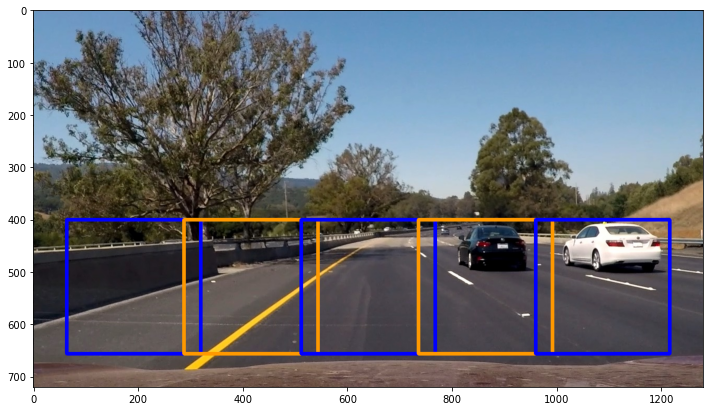

In [143]:
mc_bboxes, wins = multi_scale_pipeline(test_imgs[5], 64, 1280, 400, 656, 4, simple_classifier, normaliser, 11, 14, 2, (32, 32), 32, color_space="YCrCb", window=64, overlap_cells=4)
new_img_boxes = draw_boxes(test_imgs[5], mc_bboxes)
new_img_all_windows = draw_boxes(test_imgs[5], wins, alternating_bbox_color=(255, 153, 0))
plt.figure(figsize=(12,8))
plt.imshow(new_img_all_windows)

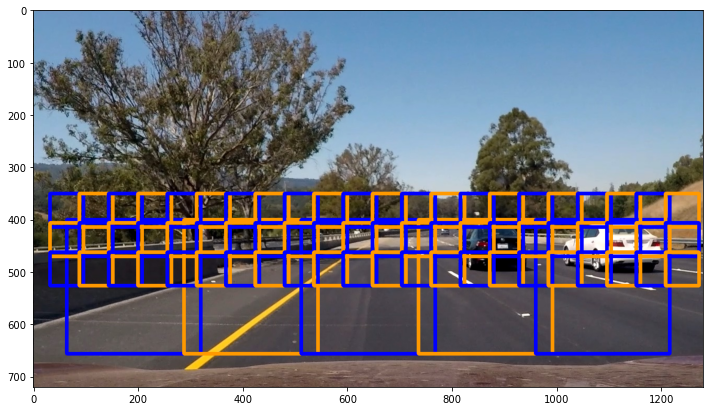

In [144]:
mc_bboxes, wins = multi_scale_pipeline(test_imgs[5], 32, 1280, 350, 550, 1, simple_classifier, normaliser, 11, 14, 2, (32, 32), 32, color_space="YCrCb", window=64, overlap_cells=4)
new_img_all_windows_2 = draw_boxes(new_img_all_windows, wins, alternating_bbox_color=(255, 153, 0))
plt.figure(figsize=(12,8))
plt.imshow(new_img_all_windows_2)

## Heatmap Thresholding

In [145]:
from scipy.ndimage.measurements import label

In [146]:
def create_heatmap(img, bbox_list):
    """
    Returns a new heatmap where the regions of the image captured by the bounding boxes are "heated-up"
    """
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    heatmap = np.clip(heatmap, 0, 255)

    return heatmap

In [147]:
def threshold_heatmap(heatmap, threshold=2):
    """
    Updates the heatmap by only retaining hot sections whose values are strictly above the threshold.
    All other values are "cooled" down
    """
    heatmap_copy = np.copy(heatmap)
    # Zero out pixels below the threshold
    heatmap_copy[heatmap_copy < threshold] = 0
    # Return thresholded map
    return heatmap_copy

In [148]:
def label_heatmap(heatmap):
    """
    Returns a slice with labels over the original heatmap, as well as the total count of labels found
    """
    return label(heatmap)

In [149]:
def find_smoothed_boxes(img, labels, duplicate=True, min_area_filter=32*32):
    """
    Returns a set of bounding boxes where each bounding box is the aggregations of neibhouring boxes for the same label
    """
    aggregate_bboxes = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        top_left = (np.min(nonzerox), np.min(nonzeroy))
        bottom_right = (np.max(nonzerox), np.max(nonzeroy))
        
        if (bottom_right[0] - top_left[0]) * (bottom_right[1] - top_left[1]) < min_area_filter:
            continue
        
        # Define a bounding box based on min/max x and y
        aggregate_bboxes.append(((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy))))
    # Return the image
    
    return aggregate_bboxes

In [150]:
def smoothen_bounding_boxes(img, bboxes, thres=2):
    
    heat = create_heatmap(img, bboxes)
    heat_thresholded = threshold_heatmap(heat, threshold=thres)
    heat_labels = label_heatmap(heat_thresholded)
    smoothed_bboxes = find_smoothed_boxes(img, heat_labels)
    
    return heat, heat_thresholded, heat_labels, smoothed_bboxes

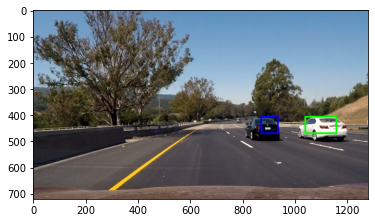

In [156]:
heatmap, heatmap_thres, heatmap_lbs, smoothed_bboxes = smoothen_bounding_boxes(test_imgs[5].astype(np.uint8), mc_bboxes, thres=1)
plt.imshow(draw_boxes(test_imgs[5], smoothed_bboxes))

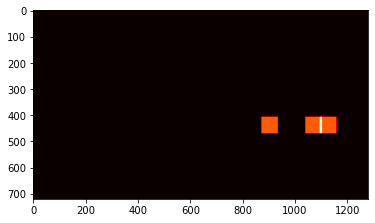

In [157]:
plt.imshow(heatmap * 255, cmap="hot")

In [163]:
def create_heatmap_rgb_img(hmap):
    """
    Create a heatmap from a binary image
    """
    scale = np.max(hmap) / 255
    if scale == 0:
        # Handle the zero case. We could also add an epsilon
        scale = 1
    z = np.zeros_like(hmap).astype(np.uint8)
    hm_scaled = (hmap / scale).astype(np.uint8)
    return np.dstack((hm_scaled, z, z))
    


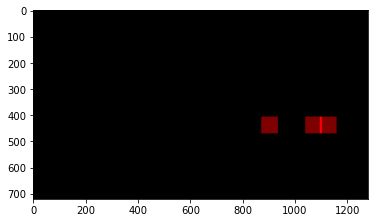

In [164]:
hm_scaled = create_heatmap_rgb_img(heatmap)
plt.imshow(hm_scaled)

# Putting It All Together

In [165]:
def draw_boxes_np(img, bboxes, color=(0, 0, 255), thick=6):
    """
    Returns a new image the bounding boxes have been overlaid in the chosen color
    The bounding boxes are contained within a numpy array
    """
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, (bbox[0][0], bbox[0][1]), (bbox[1][0], bbox[1][1]), color, thick)

    return imcopy

In [166]:
def combine_images(img, overlay_imgs, small_img_size, x_offset, y_offset):
    """
    Returns an image that combines the original image with a set of overlaid images
    The overlaid images are resized to the supplied dimensions and overlaid onto the original image.
    Note that the returned image is a modification of the original image.
    """
    
    for i, overlay_img in enumerate(overlay_imgs):        
        sc = i + 1
        small_overlay_img = cv2.resize(overlay_img, small_img_size)
        overlay_color = small_overlay_img
        if len(overlay_color.shape) < 3:
            # Create the mini-heatmap
            overlay_color = create_heatmap_rgb_img(overlay_color)
        new_y_offset = y_offset
        new_x_offset = sc * x_offset + i * small_img_size[0]
        img[new_y_offset: new_y_offset + small_img_size[1], new_x_offset: new_x_offset + small_img_size[0]] = overlay_color
    
    return img
        

In [167]:
import math
class DetectedObject:
    """
    The DetectedObject class encapsulates information about an object identified by our detector
    """
    def __init__(self, bounding_box, img_patch, frame_nb):
        self.bounding_box = bounding_box
        self.img_patch = img_patch 
        self.frame_nb = frame_nb
        self.centroid = (int((bounding_box[0][0] + bounding_box[1][0]) / 2), int((bounding_box[0][1] + bounding_box[1][1]) / 2))
        self.similar_objects = []
            
    def bounding_box_area(self):
        """
        Returns the area of the bounding box
        """
        return (self.bounding_box[1][0] - self.bounding_box[0][0]) * (self.bounding_box[1][1] - self.bounding_box[0][1])
    
    def same_object(self, detected_object):
        """
        Returns whether the current detected object is the same as the newly detected one passed as argument
        """
        # The distance between the centroids
        dist = math.hypot(detected_object.centroid[0] - self.centroid[0], detected_object.centroid[1] - self.centroid[1])
        
        if dist <= 60.0:
            return True
        
        return False
    
    def smoothe_bounding_box(self, same_object):
        """
        Smoothes the bounding boxes between the current object and the same one from another frame
        """
        print("old centroid=", self.centroid)
        self.centroid = (int((same_object.centroid[0] + self.centroid[0]) / 2), int((same_object.centroid[1] + self.centroid[1]) / 2))
        print("new centroid=", self.centroid)
        
        print("old bbox=", self.bounding_box)
        # Ideally, we want to keep the biggest possible bounding box
        current_width = self.bounding_box[1][0] - self.bounding_box[0][0]
        current_height = self.bounding_box[1][1] - self.bounding_box[0][1]

        obj_width = same_object.bounding_box[1][0] - same_object.bounding_box[0][0]
        obj_height = same_object.bounding_box[1][1] - same_object.bounding_box[0][1]
        
        max_width = max(current_width, obj_width)
        max_height = max(current_height, obj_height)
        
        half_width = int(max_width / 2)
        half_height = int(max_height / 2)
        
        new_bounding_box = np.asarray(((self.centroid[0] - half_width, self.centroid[1] - half_height),
                                       (self.centroid[0] + half_width, self.centroid[1] + half_height)))
        
        self.bounding_box = new_bounding_box
        print("new bbox=", self.bounding_box)
    
    def add_similar_object(self, similar_object):
        """
        Accumulates a similar object
        """
        self.similar_objects.append(similar_object)
    
    def similar_objects_count(self):
        """
        Returns the number of similar objects
        """
        return len(self.similar_objects)

In [168]:
class SlidingWindowConfiguration:
    """
    Represents configuration details for a set of sliding windows
    """
    def __init__(self, xstart, xstop, ystart, ystop, scale):
        self.xstart = xstart
        self.xstop = xstop
        self.ystart = ystart
        self.ystop = ystop
        self.scale = scale

In [219]:
class VehicleDetectorWithMemory:
    """
    The VehicleDetectorWithMemory is a class that is capable drawing bounding boxes around vehicles in a video
    """
    def __init__(self, better_classifier, faster_classifier, normaliser, color_space="RGB", frame_sampling_rate=5, save_frame=False, 
                 threshold=5, min_detection_count=8, debug_imgs = False, cell_overlap=4):
        self.better_classifier = better_classifier
        self.faster_classifier = faster_classifier
        self.normaliser = normaliser
        self.color_space = color_space 
        
        self.current_frame_nb = 0
        self.frame_sampling_rate = frame_sampling_rate
        self.previous_detected_objects = []
        self.current_detected_objects = []
        self.save_frame = save_frame
        self.threshold = threshold
        self.min_detection_count = min_detection_count
        self.debug_imgs = debug_imgs
        self.cell_overlap = cell_overlap
        
        # Add extra parameters such as [(ystart, ystop), (x_start, x_stop), scale] 
        # Maybe create a config object that has those and also classifier config?
        
    def process_image(self, img):
        """
        Returns a new image where the vehicles detected on the original image have been highlighted via a bounding box
        """
        
        # Save the frame for testing
        if self.save_frame and self.frame_sampling_rate > 0 and self.current_frame_nb % self.frame_sampling_rate == 0:
            cv2.imwrite("video_images/frame_{0}.png".format(self.current_frame_nb), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
            
        sw_configs =[
            SlidingWindowConfiguration(0, 1280, 400, 680, 1.8),
            #SlidingWindowConfiguration(0, 1280, 450, 680, 1.8),
            #SlidingWindowConfiguration(0, 1280, 450, 680, 1.5),
            SlidingWindowConfiguration(0, 1280, 400, 680, 1.5),
            SlidingWindowConfiguration(0, 1280, 400, 680, 1.25),
            #SlidingWindowConfiguration(0, 1280, 380, 680, 1),
            SlidingWindowConfiguration(0, 1280, 350, 680, 1)
        ]
        
        bboxes = []
        all_windows = []
        for sw_config in sw_configs:
            box, all_s_wins = multi_scale_pipeline(img, sw_config.xstart, sw_config.xstop, 
                                                   sw_config.ystart, sw_config.ystop, sw_config.scale,
                                                  self.better_classifier, self.normaliser,
                                                  11, 14, 2, (32, 32), 32, color_space=self.color_space,
                                                  window=64, overlap_cells=self.cell_overlap)
            bboxes.append(box)
            all_windows.append(all_s_wins)
        
        
        combined_boxes = []
        for i, bboxes in enumerate(bboxes):
            if len(bboxes) == 0:
                continue
            combined_boxes = np.asarray(bboxes) if len(combined_boxes) == 0 else np.concatenate((combined_boxes, np.asarray(bboxes)), axis=0)
        
        if self.debug_imgs and self.frame_sampling_rate == 0:
            for all_wins in all_windows:
                all_wins_img = draw_boxes(img, all_wins)
                plt.figure(figsize=(12,7))
                plt.imshow(all_wins_img)
                plt.show()
        
        
        all_bboxes_drawn = draw_boxes_np(img, combined_boxes)
        heatmap, heatmap_thres, heatmap_lbs, smoothed_bboxes = smoothen_bounding_boxes(img, combined_boxes, thres=self.threshold)
        
        if self.frame_sampling_rate == 0:
            drawn_smoothed_bboxes = draw_boxes(img, smoothed_bboxes)
            combined_img = combine_images(drawn_smoothed_bboxes, [heatmap, heatmap_thres, all_bboxes_drawn], (320, 200), 20, 10)
            return combined_img

        print("Found {0} bounding boxes, {1} smoothed ones and {2} labels".format(len(combined_boxes), len(smoothed_bboxes), heatmap_lbs[1]))
        
        new_detected_objects = []
        for smoothed_bbox in smoothed_bboxes:
            # create a detected object
            patch = img[smoothed_bbox[0][1]:smoothed_bbox[1][1],smoothed_bbox[0][0]:smoothed_bbox[1][0]]
            do = DetectedObject(np.asarray(smoothed_bbox), patch, self.current_frame_nb)
            if do.bounding_box_area() < 32 * 32:
                print("Skipping bounding box")
                continue
                
            #if self.current_frame_nb == 0:        
             #   self.previous_detected_objects.append(do)
            #else:
            to_append = True
            for pdo in self.current_detected_objects:
                if pdo.same_object(do):
                    print("**Found a match**")
                    pdo.smoothe_bounding_box(do)
                    pdo.add_similar_object(do)
                    to_append = False
                    #new_detected_objects.append(do)

                    break
            if to_append:
                print("Appending new object with centroid:", do.centroid)
                self.current_detected_objects.append(do)
        
        print("previously detected objects=", len(self.previous_detected_objects))
        if self.current_frame_nb > 0 and self.current_frame_nb % self.frame_sampling_rate == 0:
            retained_detected_objects = []
            # Take all detected objects in previous frames and only retain those that have more than 2 matches
            for pdo in self.current_detected_objects:
                print("number of times detected object appeared: ", pdo.similar_objects_count())
                if pdo.similar_objects_count() >= self.min_detection_count:
                    print("** Adding similar object to one with centroid {0} **".format(pdo.centroid))
                    retained_detected_objects.append(pdo)
            
            self.previous_detected_objects = retained_detected_objects
            self.current_detected_objects = []
            print("Refresh at frame n. {0}: newly detected objects {1}".format(self.current_frame_nb, len(self.previous_detected_objects)))
        else:
            print("so far newly detected objects=", len(self.current_detected_objects))
        
        
        self.current_frame_nb += 1
        if len(self.previous_detected_objects) > 0:
            bounding_boxes = []
            for ro in self.previous_detected_objects:
                bounding_boxes.append(((ro.bounding_box[0][0], ro.bounding_box[0][1]), (ro.bounding_box[1][0], ro.bounding_box[1][1])))

            smoothed_cars_bboxes = draw_boxes_np(img, bounding_boxes)
            
            combined_img = combine_images(smoothed_cars_bboxes, [heatmap, heatmap_thres, all_bboxes_drawn], (320, 200), 20, 10)
            if self.debug_imgs and (self.current_frame_nb -1)  % self.frame_sampling_rate == 0:
                plt.imshow(combined_img)
                plt.show()
                
            return smoothed_cars_bboxes
        else:
            combined_img = combine_images(img, [heatmap, heatmap_thres, all_bboxes_drawn], (320, 200), 20, 10)
            if self.debug_imgs and (self.current_frame_nb -1)  % self.frame_sampling_rate == 0:
                plt.imshow(combined_img)
                plt.show()

            return combined_img                    

## Testing with a few sample images

In [220]:
video_sample_imgs_paths = glob.glob("test_images/*.jpg", recursive=False)
print(video_sample_imgs_paths)

['test_images\\test1.jpg', 'test_images\\test2.jpg', 'test_images\\test3.jpg', 'test_images\\test4.jpg', 'test_images\\test5.jpg', 'test_images\\test6.jpg']


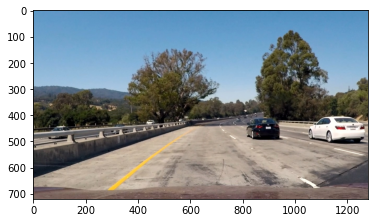

In [221]:
video_sample_imgs = np.asarray(list(map(lambda img_path: load_image(img_path), video_sample_imgs_paths)))
plt.imshow(video_sample_imgs[0])

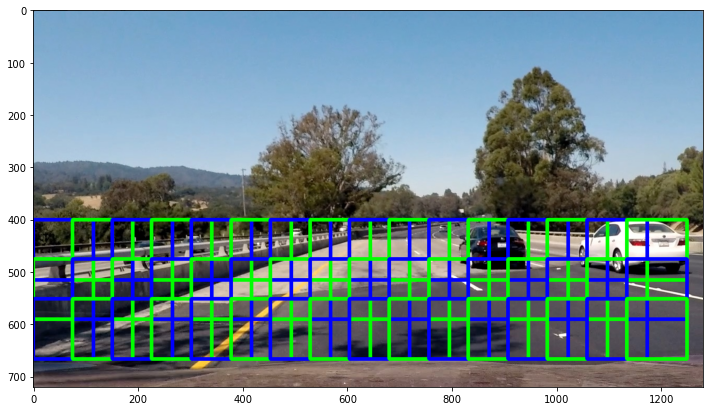

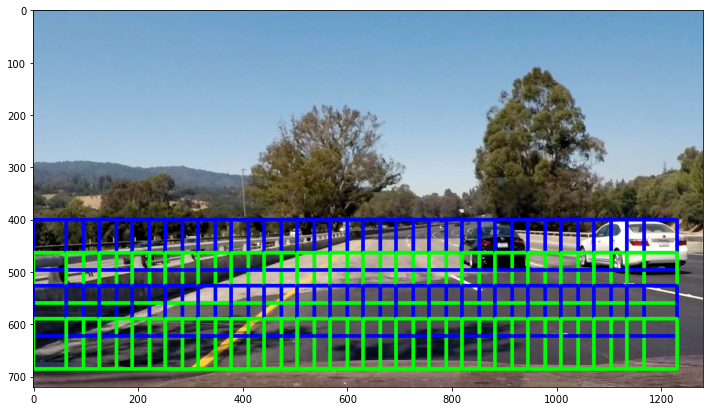

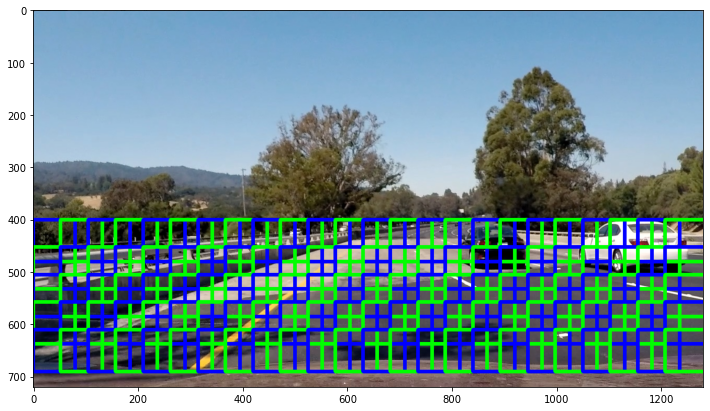

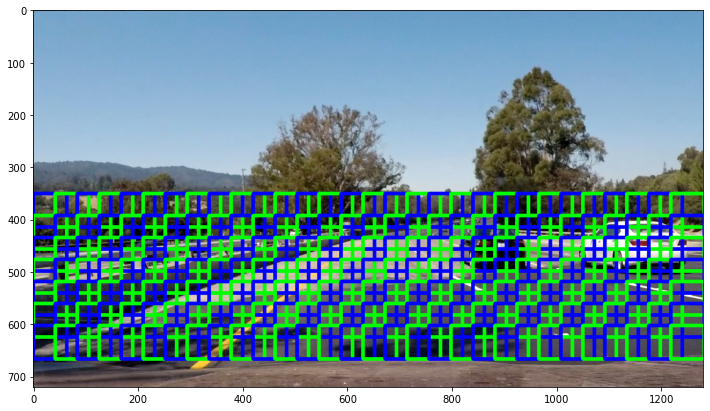

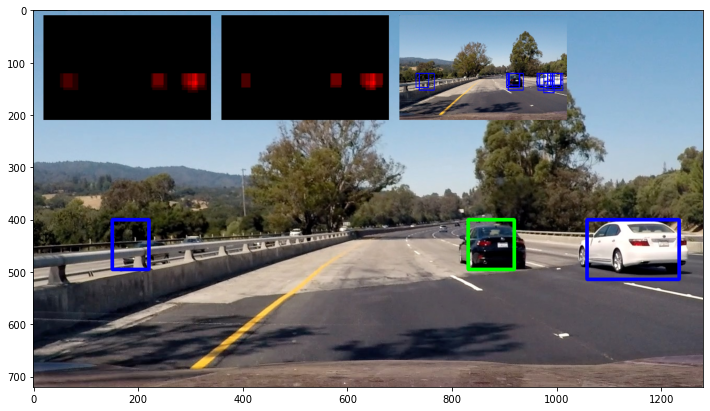

In [270]:
detector = VehicleDetectorWithMemory(better_classifier, simple_classifier, normaliser, color_space="YCrCb", 
                                     frame_sampling_rate=0, threshold=2, debug_imgs=True, cell_overlap=3)
detected_cars_img = detector.process_image(test_imgs[3])
plt.figure(figsize=(12,8))
plt.imshow(detected_cars_img)

# Results

In [215]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [253]:
project_video_path = "challenge_video.mp4"
project_video_output_path = 'challenge_video.mp4'

project_video_sample_path = 'challenge_video_test.mp4'
project_video_sample_output_path = 'challenge_video_test.mp4'

## Sample Of Project Video

In [254]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
ffmpeg_extract_subclip(project_video_path, 5, 12, targetname=project_video_sample_path)

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


In [255]:
HTML("""
<video width="900" height="600" controls>
  <source src="{0}">
</video>
""".format(project_video_sample_output_path))

In [256]:
my_gif = VideoFileClip(project_video_sample_output_path).resize(width=480)
my_gif.subclip(0,6).write_gif("media/two_cars_detected.gif", fps=15)

t:   0%|                                                                              | 0/90 [00:00<?, ?it/s, now=None]

MoviePy - Building file media/two_cars_detected.gif with imageio.


In [257]:
my_saved_img_clip = VideoFileClip(project_video_sample_output_path)
my_saved_img_clip.save_frame("media/saved_detection.png", t='00:00:5')  # saves frame at time t

In [258]:
HTML("""
<video width="900" height="600" controls>
  <source src="{0}">
</video>
""".format(project_video_output_path))